**Setup iniziale**
- Se si vuole utilizzare l'ICA portare `tryICA` a `True`
- Se si vuole provare senza la selezione dei canali portare `selectChs` a `False`
- Inserire i margini di costruzione delle epoche attorno al marker (eg. .5 e 3.5 vuol dire che le epoche inizieranno 0.5s dopo il marker e dureranno 3s)

In [30]:
tryICA = False

selectChs = True

epStart = .5
epEnd = 3.5

In [2]:
!pip install mne

import numpy as np
import mne
import scipy.io as spio
from mne.io import RawArray
from mne import create_info
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Downloading dataset

In [3]:
!wget --no-check-certificate http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip

--2023-02-08 17:29:42--  http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Resolving bbci.de (bbci.de)... 130.149.80.149
Connecting to bbci.de (bbci.de)|130.149.80.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip [following]
--2023-02-08 17:29:42--  https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Connecting to bbci.de (bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252211988 (241M) [application/zip]
Saving to: ‘BCICIV_1_mat.zip.5’

BCICIV_1_mat.zip.5  100%[===================>] 240.53M  22.9MB/s    in 11s     

2023-02-08 17:29:54 (21.8 MB/s) - ‘BCICIV_1_mat.zip.5’ saved [252211988/252211988]



In [4]:
!unzip BCICIV_1_mat.zip

Archive:  BCICIV_1_mat.zip
replace BCICIV_calib_ds1a.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: BCICIV_calib_ds1a.mat   
  inflating: BCICIV_calib_ds1b.mat   
  inflating: BCICIV_calib_ds1c.mat   
  inflating: BCICIV_calib_ds1d.mat   
  inflating: BCICIV_calib_ds1e.mat   
  inflating: BCICIV_calib_ds1f.mat   
  inflating: BCICIV_calib_ds1g.mat   
  inflating: BCICIV_eval_ds1a.mat    
  inflating: BCICIV_eval_ds1b.mat    
  inflating: BCICIV_eval_ds1c.mat    
  inflating: BCICIV_eval_ds1d.mat    
  inflating: BCICIV_eval_ds1e.mat    
  inflating: BCICIV_eval_ds1f.mat    
  inflating: BCICIV_eval_ds1g.mat    


In [5]:
# to check the directory files
!ls -la

total 1826072
drwxr-xr-x 1 root root      4096 Feb  8 17:30 .
drwxr-xr-x 1 root root      4096 Feb  8 12:36 ..
-rw-r--r-- 1 root root 252211988 Aug  3  2009 BCICIV_1_mat.zip
-rw-r--r-- 1 root root 252211988 Aug  3  2009 BCICIV_1_mat.zip.1
-rw-r--r-- 1 root root 252211988 Aug  3  2009 BCICIV_1_mat.zip.2
-rw-r--r-- 1 root root 252211988 Aug  3  2009 BCICIV_1_mat.zip.3
-rw-r--r-- 1 root root 252211988 Aug  3  2009 BCICIV_1_mat.zip.4
-rw-r--r-- 1 root root 252211988 Aug  3  2009 BCICIV_1_mat.zip.5
-rw-rw---- 1 root root  22496680 Jul  7  2008 BCICIV_calib_ds1a.mat
-rw-rw---- 1 root root  22496688 Jul  7  2008 BCICIV_calib_ds1b.mat
-rw-rw---- 1 root root  22491376 Jul  7  2008 BCICIV_calib_ds1c.mat
-rw-rw---- 1 root root  22482408 Jul  7  2008 BCICIV_calib_ds1d.mat
-rw-rw---- 1 root root  22465416 Jul  7  2008 BCICIV_calib_ds1e.mat
-rw-rw---- 1 root root  22498328 Jul  7  2008 BCICIV_calib_ds1f.mat
-rw-rw---- 1 root root  22497632 Jul  7  2008 BCICIV_calib_ds1g.mat
-rw-rw---- 1 root root  2

## Dataset and performed task explained

- Visual cues of two classes: left hand and right hand

- 2 runs of calibration with labels and cues information **(train set)**

- 4 runs of evaluation: no labels provided **(test set)**

To begin we focus on:
- 1 run for calibration/training and 
- 1 run for evaluation/testing





## Data loading

In [31]:
# Procedure explained in Lez1

curr_dir = './'
train_data = spio.loadmat(f"{curr_dir}BCICIV_calib_ds1a.mat")

eeg = train_data['cnt']
nfo = train_data['nfo']
fs = int(nfo['fs'])

classes = nfo['classes'][0,0]
clab = nfo['clab'][0,0]

chs = [c[0] for c in clab[0,:]]
n_channels = len(chs)

train_rec = RawArray(eeg.T/1e7, create_info(chs, fs, ch_types='eeg'))

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


# Cue positions and labels extraction

We have 200 samples for calibration/training.

- pos: vector of positions in time of the cue in the EEG signals given in unit sample, length #cues

- y: vector of target classes (-1 for left hand MI  or 1 for left foot MI), length #cues

In [32]:
marker = train_data['mrk']
pos = marker['pos'][0,0][0]
y = marker['y'][0,0][0]

In [33]:
# MNE works with absolute values of labels so -1 and +1 would result in only one kind of event
# that's why we add 2 and obtain 1 and 3 as label values
y = y + 2
n_samples = len(y)

# Pre-processing
This dataset comes already filtered between 0.05 Hz and 1000 Hz, powerline frequencies already removed, then downsampled at 100 Hz see for details https://www.bbci.de/competition/iv/desc_1.html.

**NOTE**: the same pre-processing applied to the training data must be applied to the test data (in this specific case we are going to use part of train_rec as test set, using the existing labels to evaluate the performance of our model, then automatically all data will be preprocessed in the same way)

## Filtering
We filter (with temporal filters) the signal to eliminate noisy components (as 50 Hz power-line noise) and non-interesting frequency components (outside of the 1-40 Hz band)


Effective window size : 2.560 (s)


<ipython-input-34-12563dd7f14f>:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  train_rec.compute_psd().plot()


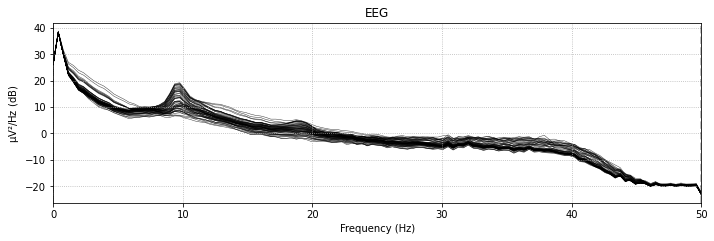

In [34]:
# At first we give a look to the PSD of the signal: 
#   being it sampled at 100 Hz, the power-line noise is already
#   not present (thanks to Nyquist)
train_rec.compute_psd().plot()

In [35]:
# Otherwise, a notch filter for powerline noise rejection could be applied like this:
#powerline_f = 50
#train_rec.notch_filter(powerline_f)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.7s finished
<ipython-input-36-edfbe8d358c1>:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  train_rec.compute_psd().plot()


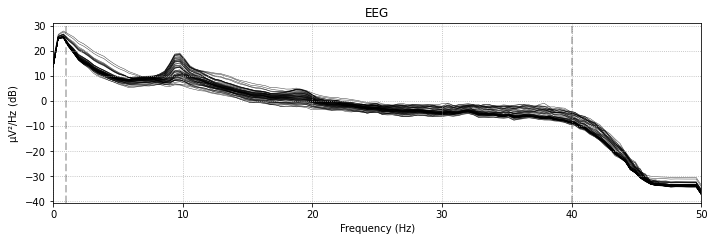

In [36]:
# band pass filter to select frequencies of 
# our interest

low_f = 1
high_f = 40
train_rec.filter(low_f,high_f)

train_rec.compute_psd().plot()

## Artifact removal 

Eye movement or facial muscles activation

We can use ICA (Independent Component Analysis) to identify particular artifacts such as eye-blink or ECG artifacts, but using ICA limits the analysis to off-line and requires expertise in recognizing the artefactual components.

Here there is anyway an example of application, but you will see that also simply thresholding the signal discrete results can be achieved. Thresholding happens directly during epoching phase.

In [37]:
if tryICA:
  from mne.preprocessing import ICA

  ica = ICA(n_components=15)
  ica.fit(train_rec)

In [38]:
if tryICA:
  ica.plot_sources(train_rec)

In [39]:
# I can use this function to see what would be the result of the elimination of 
# some of the sources individuated by ICA: in this case I'm eliminating the first 
# two sources and the eighth, because in the previous sources plot I could check
# that they don't have EEG shape
if tryICA:
  ica.plot_overlay(train_rec, exclude=[0,1,7])

In [40]:
if tryICA:
  ica.exclude = [0,1,7]
  ica.apply(train_rec)

## Epoching
In the dataset description, paragraph *Experimental Setup/Calibration data*, we can read that tasks last 4 seconds. We want to isolates epochs of signal during which the subject performs the task: so we start from the marker and keep part of the subsequent signal. 

Thresholding means rejecting an epoch if the signal, in any of the channels, exceeds a certain value: physiologically, EEG traces hardly exceed tens of μV of amplitude, then we choose as maximum peak-to-peak value 150 μV.

In [41]:
# More details on the procedure in Lez1

stim_ch = np.zeros((1,train_rec.n_times))
for ind, mrk in zip(pos,y):
  stim_ch[0,ind] = mrk

train_rec = train_rec.add_channels([RawArray(stim_ch, create_info(['STIM'], fs, ch_types='stim'))], force_update_info=True)

train_eps = mne.Epochs(train_rec,
                   mne.find_events(train_rec,'STIM'),
                   event_id=dict(class_one=1,class_two=3),
                   tmin=epStart,tmax=epEnd,
                   baseline=(None,None), 
                   reject=dict(eeg=150e-6),
                   preload=True
                   )

Creating RawArray with float64 data, n_channels=1, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
200 events found
Event IDs: [1 3]
Not setting metadata
200 matching events found
Setting baseline interval to [1.0, 3.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 201 original time points ...
    Rejecting  epoch based on EEG : ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC3', 'FC1', 'FCz']
    Rejecting  epoch based on EEG : ['AF3', 'AF4', 'F5', 'F3', 'F6']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF3', 'AF4']
    Rejecting  epoch based on EEG : ['AF3', 'AF4']
    Rejecting  epoch based on EEG : ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F4', 'F6']
    Rejecting  epoch based on EEG : ['AF3', 'AF4']
    Rejecting  epoch based on EEG : ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F6']
    Rejecting  epoch based on EEG : ['AF3'

# Feature extraction
The simplest features to evaluate a MI task are μ and β powerbands computed on central channels (motor cortex is on the anterior side of the central sulcus), so we are going to build a features matrix which in each row contains these powerbands for all CFC and C channels (chs 16-23, 25-31).

There are different ways to extract bandpowers: in this code we proceed creating copies of the original epoched signal, one filtered in  the μ-band and the other in the β-band. Than we square each single epoch, compute its mean and take its logarithm. Doing this for both the replicas in each of their channels allows to extract the powerbands and build the feature matrix.

In [42]:
if selectChs:
  # Extracts only interesting channels
  interesting_chs = train_rec.ch_names[16:24]+train_rec.ch_names[25:32]
else:
  interesting_chs = train_rec.ch_names[0:-1]

featExt_eps = train_eps.copy()
featExt_eps.load_data().pick_channels(interesting_chs)

# Creates mu-filtered replica
low_f = 7
high_f = 13
eps_mu = featExt_eps.copy()
eps_mu = eps_mu.load_data().filter(low_f,high_f).get_data()

# Creates beta-filtered replica
low_f = 15
high_f = 30
eps_beta = featExt_eps.copy()
eps_beta = eps_beta.load_data().filter(low_f,high_f).get_data()

Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 15 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 89 samples (0.890 sec)



[Parallel(n_jobs=1)]: Done 8201 out of 8201 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 8201 out of 8201 | elapsed:    6.6s finished


In [43]:
n_epochs = len(train_eps)
feature_array = np.zeros((n_epochs,len(interesting_chs)*2)) # two features for each channel

for ep in range(n_epochs):
  for ch in range(len(interesting_chs)):
    feature_array[ep,ch*2] = np.log(np.mean(eps_mu[ep,ch,:]**2))
    feature_array[ep,ch*2+1] = np.log(np.mean(eps_beta[ep,ch,:]**2))


# Classification with Scikit Learn

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [50]:
# Scaling could be useful depending on which model is being used for the classification
feature_array = preprocessing.StandardScaler().fit_transform(feature_array)

In [51]:
# Labels list extracted from the original data
y = train_eps.events[:,2]

# Training set and test set are generated splitting the data 
# Only the training set will be used to fit the model to our case, while the test set
# will be used to evaluate the model performance

X_train, X_test, y_train, y_test = train_test_split(feature_array, y, test_size=.2, random_state=42,shuffle = True)

In [52]:
logreg = LogisticRegression()
svm = SVC(probability=True)

In [53]:
logreg.fit(X_train, y_train)
score = logreg.score(X_test, y_test)
score

0.7142857142857143

In [54]:
svm.fit(X_train, y_train)
score = svm.score(X_test, y_test)
score

0.6071428571428571